In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import requests

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Data Joining")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "9g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

24/09/18 22:30:02 WARN Utils: Your hostname, LAPTOP-406UJ3L3 resolves to a loopback address: 127.0.1.1; using 172.22.142.206 instead (on interface eth0)
24/09/18 22:30:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/18 22:30:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/18 22:30:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Information on merchants
merchant = spark.read.parquet("../data/curated/part_1/clean_merchant.parquet")

# Information on merchant's fraud probability
merchant_fraud_prob = pd.read_csv("../data/tables/part_1/merchant_fraud_probability.csv")

In [4]:
merchant.limit(5)

merchant_abn,name,goods,revenue_level,take_rate,sum(dollar_value),count(dollar_value),log_ratio,unscaled_earning
12516851436,Mollis Corp.,"watch, clock, and...",a,6.71,32325.484349738046,210,5.036503656560932,2169.0399998674225
15613631617,Ante Industries,motor vehicle sup...,e,0.35,543030.5313328261,1785,5.717747130253923,1900.6068596648913
19839532017,Pellentesque Habi...,"cable, satellite,...",b,4.94,113982.0,726,5.056245805348308,5630.710800000001
34440496342,Mauris Nulla Inte...,"opticians, optica...",c,2.85,19425.358828709985,215,4.503696619458033,553.6227266182345
35344855546,Quis Tristique Ac...,"watch, clock, and...",c,2.92,134737.25046268434,1522,4.483301329640816,3934.327713510383


In [5]:
goods = merchant.select("goods")

In [6]:
from pyspark.ml.feature import CountVectorizer, PCA
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import CountVectorizer, StopWordsRemover
from pyspark.ml.feature import Tokenizer

In [7]:
clean_goods = goods.withColumn("str_goods", lower(regexp_replace("goods", "[^\w\s]", "")))

tokenizer = Tokenizer(inputCol="str_goods", outputCol="tokens")
clean_goods = tokenizer.transform(clean_goods)

remover = StopWordsRemover(inputCol="tokens", outputCol="clean_goods")
clean_goods = remover.transform(clean_goods)

In [8]:
clean_goods = clean_goods.select('clean_goods')

In [9]:
count_vectorizer = CountVectorizer(inputCol="clean_goods", outputCol="features")

model = count_vectorizer.fit(clean_goods)
result = model.transform(clean_goods)

In [10]:
result.select("features").collect()[4][0]

SparseVector(94, {0: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 51: 1.0})

In [11]:
result

clean_goods,features
"[watch, clock, je...","(94,[0,12,13,14,5..."
"[motor, vehicle, ...","(94,[5,71,72,76,7..."
"[cable, satellite...","(94,[4,44,45,46,4..."
"[opticians, optic...","(94,[9,73,74,75],..."
"[watch, clock, je...","(94,[0,12,13,14,5..."
"[antique, shops, ...","(94,[0,1,4,11,86,..."
"[tent, awning, sh...","(94,[0,42,43],[1...."
"[bicycle, shops, ...","(94,[0,1,11,49,50..."
"[motor, vehicle, ...","(94,[5,71,72,76,7..."
"[motor, vehicle, ...","(94,[5,71,72,76,7..."


In [12]:
for i in range(5, 20, 2):
    pca = PCA(k=i, inputCol="features")
    pca.setOutputCol("pca_features")
    
    model = pca.fit(result)
    print(model.explainedVariance.sum())
    print(model.explainedVariance)
    print("\n")

24/09/18 21:11:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


0.41950735205708073
[0.10246262638878294,0.1004933066939718,0.08346289604756785,0.07332809942178989,0.0597604235049683]


0.5253963095342261
[0.10246262638878294,0.1004933066939718,0.08346289604756785,0.07332809942178989,0.0597604235049683,0.05417955561454173,0.05170940186260361]


0.613815873970536
[0.10246262638878294,0.1004933066939718,0.08346289604756785,0.07332809942178989,0.0597604235049683,0.05417955561454173,0.05170940186260361,0.04522857745059118,0.04319098698571872]


0.6964486560224578
[0.10246262638878294,0.1004933066939718,0.08346289604756785,0.07332809942178989,0.0597604235049683,0.05417955561454173,0.05170940186260361,0.04522857745059118,0.04319098698571872,0.04196845723722473,0.0406643248146969]


0.7689536734849916
[0.10246262638878294,0.1004933066939718,0.08346289604756785,0.07332809942178989,0.0597604235049683,0.05417955561454173,0.05170940186260361,0.04522857745059118,0.04319098698571872,0.04196845723722473,0.0406643248146969,0.03835490393057878,0.034150113531955004

In [13]:
pca = PCA(k=15, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(result)
pca_result = model.transform(result)

In [14]:
model.getK()

15

In [15]:
model.transform(result).collect()[0].pca_features

DenseVector([0.7685, -0.6656, 0.3307, -0.7595, -0.0918, -0.2737, 0.9877, 1.0146, 0.314, 0.568, -0.028, -0.0165, 0.0851, 0.425, 0.009])

In [16]:
model.explainedVariance.sum()

np.float64(0.8304024938189664)

In [8]:
temp = spark.read.parquet('../data/curated/all_details/')

temp.limit(5)

order_id,user_id,merchant_abn,order_datetime,dollar_value,postcode,merchant_fraud,consumer_fraud,weekly_personal_disposable,median_total_household_income,median_total_family_income,avg_household_size,median_age,is_po_box,sa2_code,sa2_name
6a84c3cf-612a-457...,2,15549624934,2021-08-20,130.3505283105634,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
a1ff2d13-c888-469...,2,79417999332,2021-08-21,132.70580024651548,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
ccdb41fa-a5ab-472...,2,64203420245,2021-08-21,3.0641677344299336,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
4fbc20d0-1e21-4b5...,2,66842618444,2021-08-19,189.45042103113855,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
c7acb95f-2cf8-4ae...,2,30122382323,2021-08-22,37.72939540011015,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls


In [9]:
full_dataset = temp.join(merchant, on='merchant_abn', how='left')
full_dataset.limit(5)

merchant_abn,order_id,user_id,order_datetime,dollar_value,postcode,merchant_fraud,consumer_fraud,weekly_personal_disposable,median_total_household_income,median_total_family_income,avg_household_size,median_age,is_po_box,sa2_code,sa2_name,name,goods,revenue_level,take_rate,sum(dollar_value),count(dollar_value),log_ratio,unscaled_earning
15549624934,6a84c3cf-612a-457...,2,2021-08-20,130.3505283105634,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls,Commodo Associates,"opticians, optica...",c,2.76,188412.2599219474,2080,4.506264540207509,5200.178373845748
79417999332,a1ff2d13-c888-469...,2,2021-08-21,132.70580024651548,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls,Phasellus At Company,"gift, card, novel...",b,4.95,9126402.79723238,99226,4.521526821115149,451756.93846300285
64203420245,ccdb41fa-a5ab-472...,2,2021-08-21,3.0641677344299336,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls,Pede Nonummy Corp.,tent and awning s...,c,2.86,7549445.230212996,260780,3.3655522201060104,215914.13358409167
66842618444,4fbc20d0-1e21-4b5...,2,2021-08-19,189.45042103113855,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls,Ultrices Inc.,shoe shops,a,6.93,1291622.8696263728,5282,5.499349931283495,89509.46486510764
30122382323,c7acb95f-2cf8-4ae...,2,2021-08-22,37.72939540011015,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls,Ipsum Company,"watch, clock, and...",b,3.36,848058.8015739289,21154,3.6911209619607224,28494.77573288401


In [10]:
merchant_is_fraud_model = full_dataset.select(["merchant_abn", "user_id", "order_datetime", "dollar_value", "postcode", "merchant_fraud", "weekly_personal_disposable",
                     "median_total_household_income", "median_total_family_income", "avg_household_size", "median_age", "is_po_box", "goods", "revenue_level" ,"take_rate"])

In [20]:
merchant_is_fraud_model.limit(5)

merchant_abn,user_id,order_datetime,dollar_value,postcode,merchant_fraud,weekly_personal_disposable,median_total_household_income,median_total_family_income,avg_household_size,median_age,is_po_box,goods,revenue_level,take_rate
15549624934,2,2021-08-20,130.3505283105634,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,"opticians, optica...",c,2.76
79417999332,2,2021-08-21,132.70580024651548,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,"gift, card, novel...",b,4.95
64203420245,2,2021-08-21,3.0641677344299336,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,tent and awning s...,c,2.86
66842618444,2,2021-08-19,189.45042103113855,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,shoe shops,a,6.93
30122382323,2,2021-08-22,37.72939540011015,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,"watch, clock, and...",b,3.36


In [47]:
merchant_is_fraud_model.filter(F.col('merchant_fraud') > 0).count()

4059

In [11]:
from pyspark.sql.functions import year

In [12]:
# Calculate sizes for each part
total_sample_size = int(merchant_is_fraud_model.count() * 0.1)
size_2021 = int(total_sample_size * 0.7)
size_other = total_sample_size - size_2021 

data_2021 = merchant_is_fraud_model.filter(year(merchant_is_fraud_model['order_datetime']) == 2021)
data_other = merchant_is_fraud_model.filter(year(merchant_is_fraud_model['order_datetime']) != 2021)

# Get 70% 2021 and 30# of 2022
sample_2021 = data_2021.sample(size_2021/data_2021.count(), seed=42)
sample_other = data_other.sample(size_other/data_other.count(), seed=42)

# Combine the two samples
merchant_fraud_df = sample_2021.union(sample_other).toPandas()

In [13]:
merchant_fraud_df.shape

(1420623, 15)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

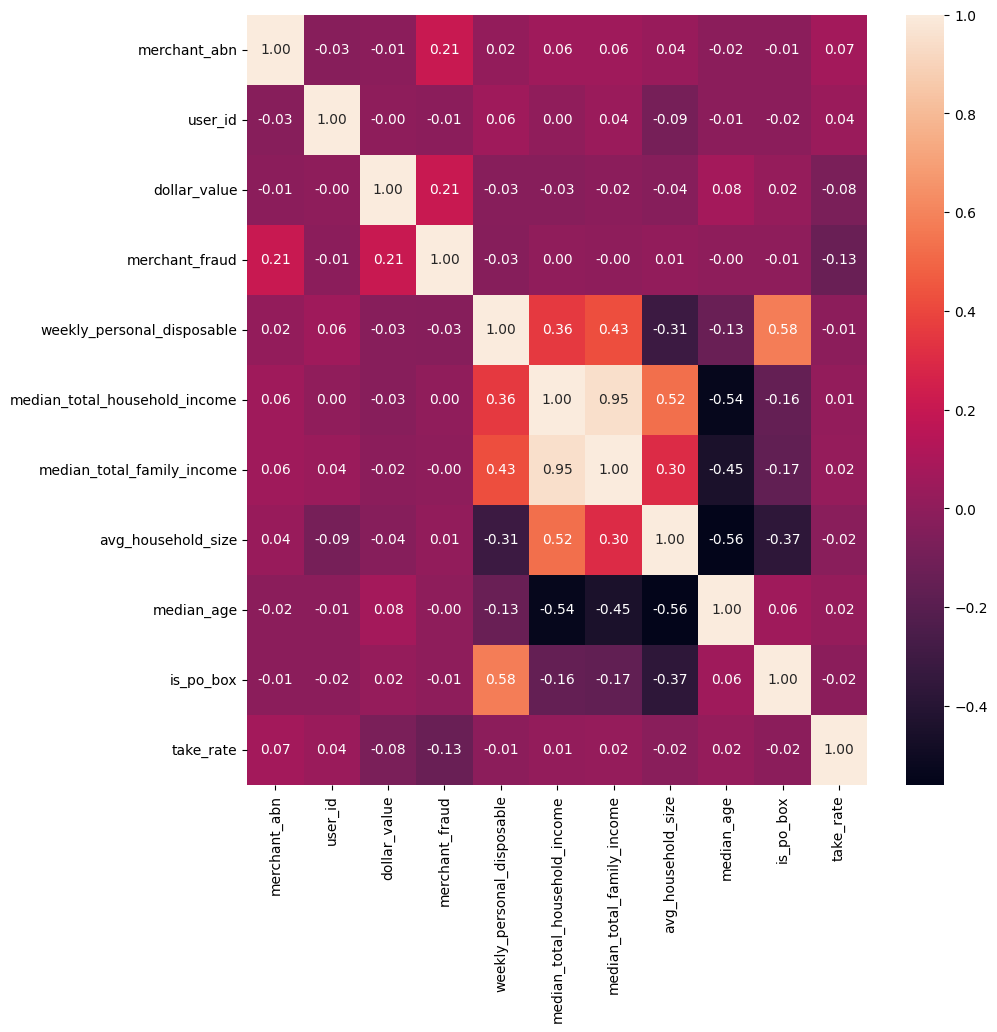

In [15]:
num_cols = [col for col in merchant_fraud_df.columns if merchant_fraud_df[col].dtype != 'object']

plt.figure(figsize=(10, 10))
sns.heatmap(merchant_fraud_df.loc[merchant_fraud_df['merchant_fraud'] > 0][num_cols].corr(), annot=True, fmt='.2f')

In [16]:
selected_features = ["merchant_abn", "dollar_value", "merchant_fraud", "weekly_personal_disposable", "goods", "revenue_level" ,"take_rate", "order_datetime"]
model_df = merchant_fraud_df[selected_features]

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [18]:
model_df = model_df[model_df.goods.isna() == False].reset_index(drop=True)

In [19]:
model_df.shape

(1362359, 8)

In [20]:
def clean_text(text):
    text = text.lower()  
    text = re.sub(r'[^\w\s]', '', text) 
    return text

model_df['str_goods'] = model_df['goods'].apply(clean_text)
model_df['tokens'] = model_df['str_goods'].apply(lambda x: x.split())
stop_words = set(['is', 'a', 'the', 'for', 'and', 'to', 'of', 'this']) 
model_df['clean_goods'] = model_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])


model_df['clean_goods_str'] = model_df['clean_goods'].apply(lambda x: ' '.join(x))


count_vectorizer = CountVectorizer()
features = count_vectorizer.fit_transform(model_df['clean_goods_str'])

In [21]:
scaler = StandardScaler(with_mean=False)
scaled_data = scaler.fit_transform(features)

pca = PCA(n_components=13)  
principal_components = pca.fit_transform(scaled_data)

In [22]:
pca.explained_variance_ratio_

array([0.07903047, 0.07191432, 0.06981799, 0.06012178, 0.05946448,
       0.0550978 , 0.05337353, 0.05179395, 0.04764209, 0.04692672,
       0.04493289, 0.0439642 , 0.04114569])

In [23]:
pca.explained_variance_ratio_.cumsum()

array([0.07903047, 0.15094479, 0.22076279, 0.28088457, 0.34034905,
       0.39544684, 0.44882037, 0.50061432, 0.54825642, 0.59518314,
       0.64011603, 0.68408023, 0.72522592])

In [24]:
pca_df = pd.DataFrame(data=principal_components)

In [25]:
final_df = pd.concat([model_df, pca_df], axis=1).drop(['str_goods', 'tokens', 'clean_goods', 'clean_goods_str', 'goods', 'merchant_abn'], axis=1)

In [26]:
ordered_categories = ['a', 'b', 'c', 'd', 'e']
final_df['ordinal_revenue_level'] = pd.Categorical(final_df['revenue_level'], categories=ordered_categories, ordered=True)

In [27]:
final_df['ordinal_revenue_level'] = final_df['ordinal_revenue_level'].cat.codes

In [28]:
final_df = final_df.drop('revenue_level', axis=1)

In [29]:
final_df.shape

(1362359, 19)

## Train model to predict NULL fraud probability

In [37]:
final_df[final_df.merchant_fraud == 0].shape

(1361804, 19)

In [30]:
final_df['order_datetime'] = pd.to_datetime(final_df['order_datetime'])

In [31]:
X_train = final_df[final_df['order_datetime'].dt.year == 2021].drop('merchant_fraud', axis=1)
X_test = final_df[final_df['order_datetime'].dt.year == 2022].drop('merchant_fraud', axis=1)

y_train = final_df[final_df['order_datetime'].dt.year == 2021]['merchant_fraud']
y_test = final_df[final_df['order_datetime'].dt.year == 2022]['merchant_fraud']

In [32]:
X_train.shape

(953695, 18)

In [33]:
X_test.shape

(408664, 18)

In [34]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression().fit(X_train, y)
reg.score(X, y)
reg.coef_
reg.intercept_
reg.predict(np.array([[3, 5]]))